In [1]:
import tifffile as tif
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import center_of_mass as com
from scipy.optimize import curve_fit
import os
from scipy.signal import detrend
import scipy.io as sio
from tqdm import tqdm_notebook as tqdm
import math

from mda import *
from time import sleep

In [2]:
import matplotlib
%matplotlib notebook

#Needs to follow inline magick command

plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'viridis'

### Load mda file

In [3]:
scan_number=95
path='/CNMshare/savedata/2018R3/20181211/mda/26idbSOFT_%04d'  %scan_number #Scan path
data=readMDA(path, showHelp=0)
c=11 #Channel number
d=data[2].d[c-1].data
t=data[2].d[c-1].fieldName
d=np.asarray(d)

### Load tiffs

In [4]:
imgsperpt=1 #Acquisitions per scan point
ny, nx=d.shape[1],d.shape[0] #Scan dimensions
scan_number=95
path='/CNMshare/savedata/2018R3/20181211/Images/%d/'  %scan_number #Scan path

#ROI of data you want to analyze
roix1=128
dx=160
roix2=roix1+dx
roiy1=150
dy=192
roiy2=roiy1+dy

detx,dety=512,512

In [5]:
files=sorted(os.listdir(path))
nfiles=len(files)
npts=ny*nx


data=np.zeros((npts,roiy2-roiy1,roix2-roix1),float)
i,j=0,0
for fl in tqdm(files):
    data[i,:,:]=tif.imread(path+fl)[roiy1:roiy2,roix1:roix2]
    j+=1
    if(j%imgsperpt==0): i+=1
    if(i>=npts): break
print (i,j, data.shape)
data=data.reshape(ny,nx, dy, dx)
print (i,j, data.shape)

2091 2091 (2091, 192, 160)
2091 2091 (51, 41, 192, 160)


<IPython.core.display.Javascript object>


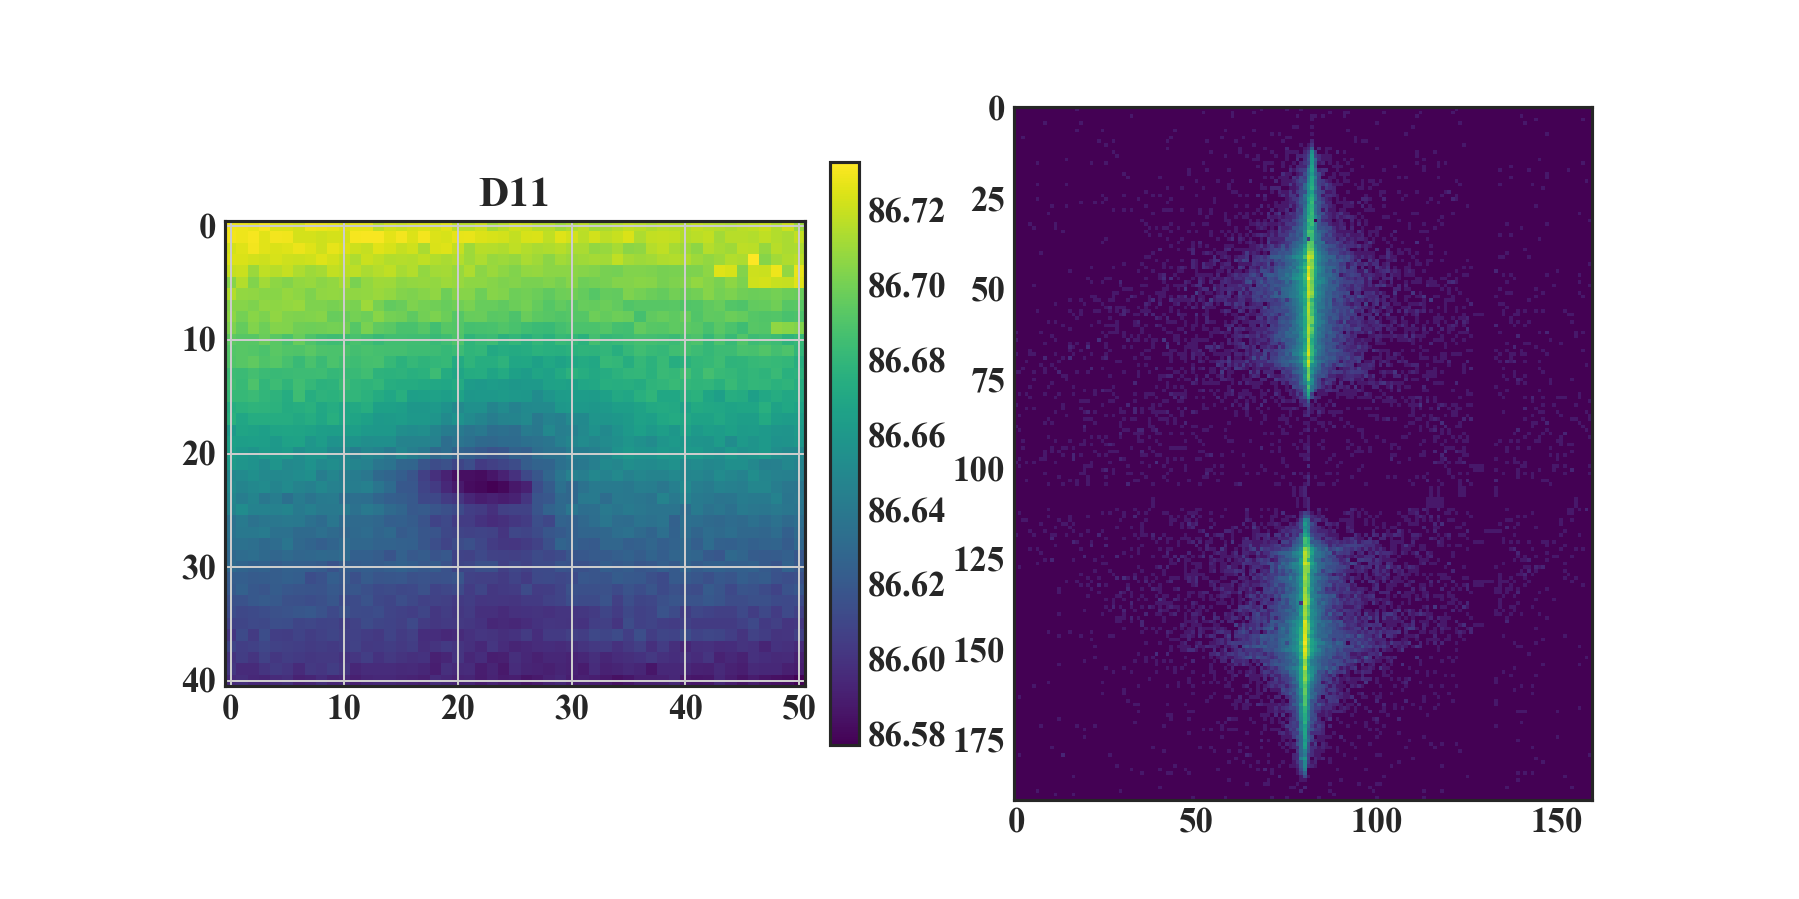

interactive(children=(IntSlider(value=25, description='x', max=50), IntSlider(value=20, continuous_update=Fals…

<function __main__.update(x=25, y=20)>

In [139]:
from ipywidgets import *
import matplotlib.ticker as plticker
pos=[]
fig, ax = plt.subplots(1,2, figsize=(10,5))
im=ax[0].imshow(d)
cb=plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title(t)
ax[0].grid()
loc=plticker.MultipleLocator(base=10)
ax[0].xaxis.set_major_locator(loc)


coords=[]
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    global coords
    coords.append([ix,iy])
    return int(ix),int(iy)


def update(x = int(data.shape[0]/2), y=int(data.shape[1]/2)):
    im=ax[1].imshow(np.log10(data[y,x,:,:]+1))
#    cb=plt.colorbar(im, ax=ax[1])
    fig.canvas.draw()
    
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

interact(update, y=widgets.IntSlider(min=0,max=data.shape[1]-1,step=1,value=int(data.shape[1]/2), 
                                     continuous_update=False),
                 x=widgets.IntSlider(min=0,max=data.shape[0]-1,step=1,value=int(data.shape[0]/2)), 
                                     continuous_update=False)

In [141]:
ix,iy, coords

(21.748075710201586,
 24.316844720102587,
 [[33.627796187366826, 24.79203353918919],
  [21.748075710201586, 24.316844720102587]])

<IPython.core.display.Javascript object>


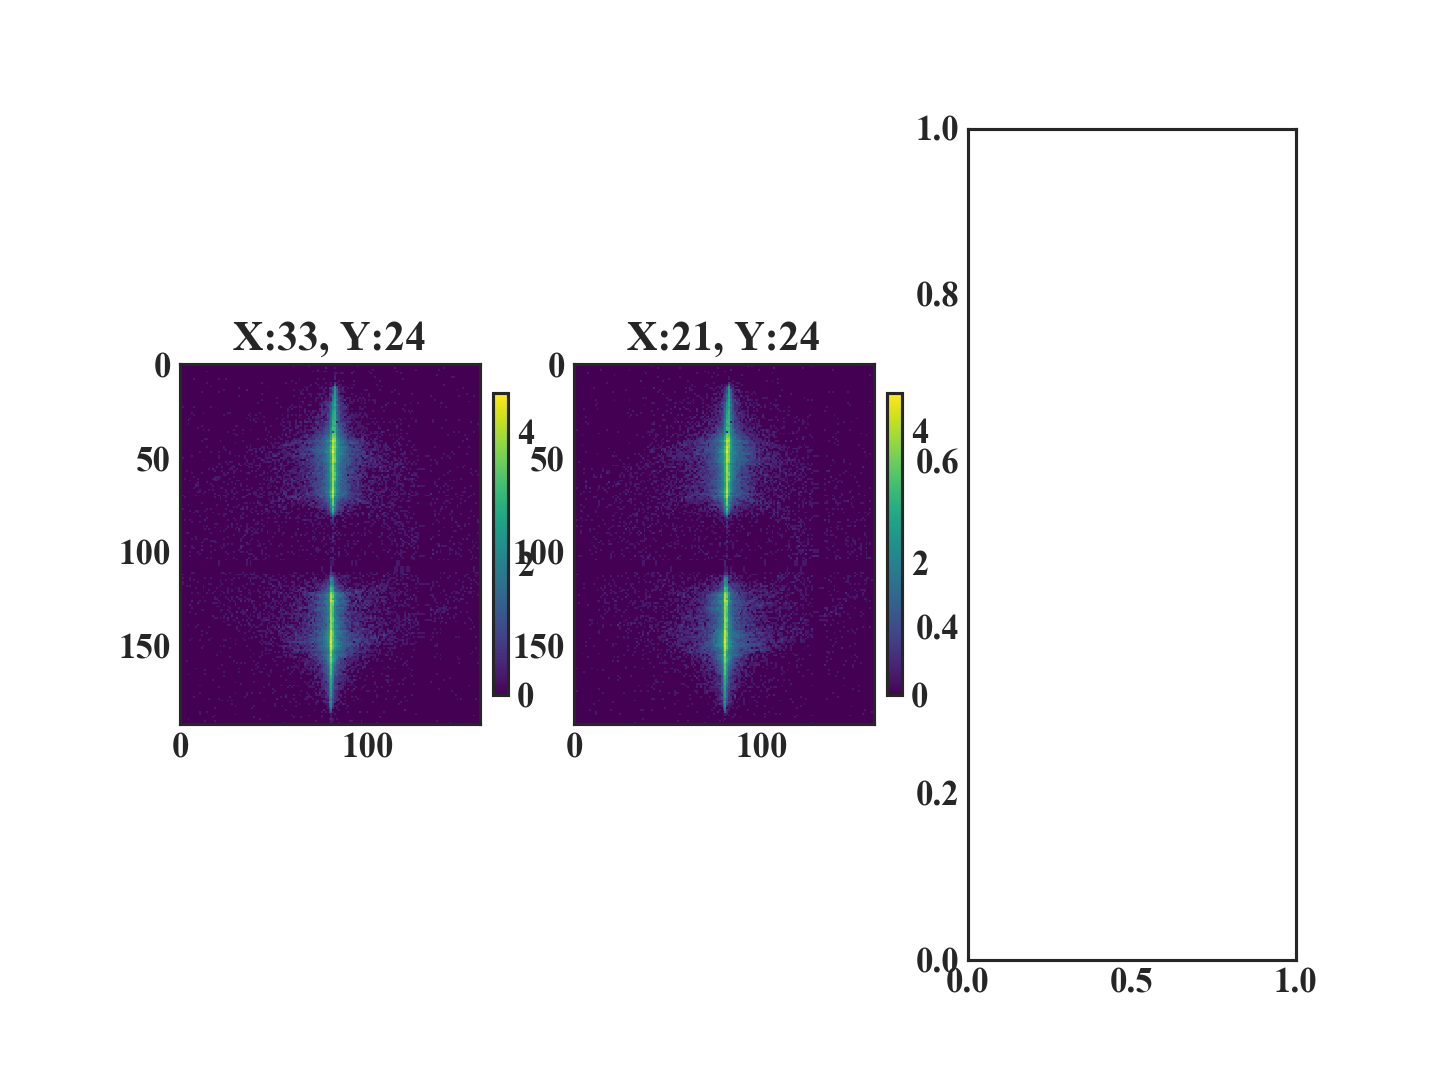

In [143]:
px=int(math.ceil(len(coords)/3))
#fig, ax = plt.subplots(px,3, figsize=(px*10,9))
i,j=0,0

if (px>1):
    fig, ax2 = plt.subplots(px,3, figsize=(8,(px-1)*6))
    fig.tight_layout(pad=0)
    for c in coords:
        ix,iy=int(c[0]),int(c[1])
        if(ix<data.shape[0] and iy<data.shape[1]):
            im=ax2[i,j].imshow(np.log10(data[ix,iy,:,:]+1))
            cb=plt.colorbar(im, ax=ax2[i,j])
            ax[i,j].set_title('X: %d, Y:%d' %(ix,iy))
            j+=1
            if(j%3==0 and j>0):
                j=0
                i+=1
else:
    fig, ax2 = plt.subplots(px,3, figsize=(8,6))
    for c in coords:
        ix,iy=int(c[0]),int(c[1])
        im=ax2[j].imshow(np.log10(data[ix,iy,:,:]+1))
        cb=plt.colorbar(im, ax=ax2[j],fraction=0.046, pad=0.04)
        ax2[j].set_title('X:%d, Y:%d' %(ix,iy))
        j+=1